<a href="https://colab.research.google.com/github/tsitsvero/rotor-gp/blob/main/pack/train_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

In [ ]:
!pip install git+https://github.com/lab-cosmo/librascal gpytorch pytorch-lightning wandb git+https://github.com/chem-gp/fande xtb nbstripout
! nbstripout --install --global

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Cooking up the model

In [ ]:
# Prepare the training data:

from ase import io
import os

DATA_DIR = os.path.expanduser("~/repos/data/")
# DATA_DIR = "/data1/simulations/datasets/rotors/high_temp_ML_training_data/"
RESULTS_DIR = os.path.expanduser("~/repos/data/results")

# DATA_DIR = os.path.expanduser("/content/drive/MyDrive/data/")
# # FANDE_DIR = os.path.expanduser("~/")
# RESULTS_DIR = os.path.expanduser("/content/results")
# os.makedirs(RESULTS_DIR, exist_ok=True)

PREPARE_DATA = True
if PREPARE_DATA:
        traj_295 = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_295_295K/md_trajectory.traj", index=":")
        # traj_355 = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_355_355K/md_trajectory.traj", index=":")
        traj_295_2000K = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_295_2000K/md_trajectory.traj", index=":")
        # traj_355_2000K = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_355_2000K/md_trajectory.traj", index=":")
        # traj_295_2000K_forced = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_295_2000K_0075force/md_trajectory.traj", index=":")
        # traj_355_2000K_forced = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_355_2000K_0075force/md_trajectory.traj", index=":")

        # trajectory_energy = traj_295[0:5000] + traj_355[0:5000] + traj_295_2000K[0:5000] + traj_355_2000K[0:5000] + traj_295_2000K_forced[0:5000] + traj_355_2000K_forced[0:5000]

        train_energy = traj_295[0:5000:10] +  traj_295_2000K[0:5000:10]
        train_forces = traj_295_2000K[0:5000:5]
        validation_energy = traj_295[1000:1010]
        validation_forces = traj_295[1000:1010]

        io.write(DATA_DIR+"/train_energy.traj", train_energy)
        io.write(DATA_DIR+"/train_forces.traj", train_forces)
        io.write(DATA_DIR+"/validation_energy.traj", validation_energy)
        io.write(DATA_DIR+"/validation_forces.traj", validation_forces)


In [ ]:
ENERGY_MODEL = 'variational_inducing_points' #'variational_inducing_points', 'exact'
ENERGY_NUM_INDUCING_POINTS = 10
ENERGY_LR = 0.1
ENERGY_NUM_STEPS = 5

FORCES_MODEL = 'variational_inducing_points' #'variational_inducing_points', 'exact'
FORCES_NUM_INDUCING_POINTS = 10
NUM_FORCE_SAMPLES = 10
FORCES_LR = 0.1
FORCES_NUM_STEPS = 5

PREDICTOR_NAME = 'test.pth'
SUBSAMPLE = 2 # subsample data to reduce time durings tests

! python cook_model.py \
--data_dir $DATA_DIR \
--results_dir $RESULTS_DIR \
--energy_model $ENERGY_MODEL \
--energy_num_inducing_points $ENERGY_NUM_INDUCING_POINTS \
--energy_lr $ENERGY_LR \
--energy_num_steps $ENERGY_NUM_STEPS \
--forces_model $FORCES_MODEL \
--forces_num_inducing_points $FORCES_NUM_INDUCING_POINTS \
--num_force_samples $NUM_FORCE_SAMPLES \
--forces_lr $FORCES_LR \
--forces_num_steps $FORCES_NUM_STEPS \
--predictor_name $PREDICTOR_NAME \
--subsample $SUBSAMPLE


## Testing models

In [40]:
from ase import io
# test_traj = io.read(DATA_DIR + "for_test_jacs/295_0.075_same_+/md_trajectory.traj", index="0:200")
test_traj = io.read(DATA_DIR + "295_0.075_same_+/md_trajectory.traj", index="0:200")
# test_traj = io.read(DATA_DIR + "/results_triasine_ML_2000/struct_295_295K/md_trajectory.traj", index="1000:1200")

In [43]:
# view(test_traj)
io.write(RESULTS_DIR + "/test_traj.xyz", test_traj, format="xyz")

In [ ]:
# from ase.visualize import view
# view(test_traj)

In [34]:
import sys
import torch
import os

# DATA_DIR = os.path.expanduser("~/repos/data/")
# DATA_DIR = "/data1/simulations/datasets/rotors/high_temp_ML_training_data/"
# RESULTS_DIR = os.path.expanduser("~/repos/data/results")
DATA_DIR = "/data1/simulations/datasets/rotors/high_temp_ML_training_data/"
# RESULTS_DIR = os.path.expanduser("~/repos/data/results")
RESULTS_DIR = os.path.expanduser("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results")

# DATA_DIR = os.path.expanduser("/content/drive/MyDrive/data/")
# # FANDE_DIR = os.path.expanduser("~/")
# RESULTS_DIR = os.path.expanduser("/content/results")

FANDE_DIR = os.path.expanduser("~/repos/")
sys.path.append(FANDE_DIR + "fande/")

from fande.predict import FandePredictor
from fande.ase import FandeCalc
# load the predictor:
# predictor_loaded = torch.load(RESULTS_DIR + "/fande_predictor.pth")
predictor_exact = torch.load(RESULTS_DIR + "/exact.pth")
fande_calc_exact = FandeCalc(predictor_exact)

predictor_exact_500points = torch.load(RESULTS_DIR + "/exact_500points.pth")
fande_calc_exact_500points = FandeCalc(predictor_exact_500points)

predictor_inducing = torch.load(RESULTS_DIR + "/inducing.pth")
fande_calc_inducing = FandeCalc(predictor_inducing)



# device = torch.device('cpu')
# fande_calc_exact.predictor.move_models_to_device(device)
# fande_calc_inducing.predictor.move_models_to_device(device)

In [35]:
%%capture c
#16 mins
from tqdm import tqdm
forces_true = []
energy_true = []

forces_predicted_exact = []
forces_predicted_variance_exact = []
energy_predicted_exact = []
energy_predicted_variance_exact = []

forces_predicted_exact_500points = []
forces_predicted_variance_exact_500points = []
energy_predicted_exact_500points = []
energy_predicted_variance_exact_500points = []

forces_predicted_inducing = []
forces_predicted_variance_inducing = []
energy_predicted_inducing = [] 
energy_predicted_variance_inducing = []


for atoms in test_traj[1:]:
    forces_true.append(atoms.get_forces())
    energy_true.append(atoms.get_potential_energy())

    atoms.set_calculator(fande_calc_exact)
    energy_predicted_exact.append(atoms.get_potential_energy())
    energy_predicted_variance_exact.append(atoms.calc.energy_variance)
    forces_predicted_exact.append(atoms.calc.forces)
    forces_predicted_variance_exact.append(atoms.calc.forces_variance)

    atoms.calc = fande_calc_exact_500points
    energy_predicted_exact_500points.append(atoms.get_potential_energy())
    energy_predicted_variance_exact_500points.append(atoms.calc.energy_variance)
    forces_predicted_exact_500points.append(atoms.calc.forces)
    forces_predicted_variance_exact_500points.append(atoms.calc.forces_variance)
    
    atoms.calc = fande_calc_inducing
    energy_predicted_inducing.append(atoms.get_potential_energy())
    energy_predicted_variance_inducing.append(atoms.calc.energy_variance)
    forces_predicted_inducing.append(atoms.calc.forces)
    forces_predicted_variance_inducing.append(atoms.calc.forces_variance)

In [36]:
import numpy as np

energy_true = np.array(energy_true)
forces_true = np.array(forces_true)

energy_predicted_exact = np.array(energy_predicted_exact)
energy_predicted_variance_exact = np.array(energy_predicted_variance_exact)
forces_predicted_exact = np.array(forces_predicted_exact)
forces_predicted_variance_exact = np.array(forces_predicted_variance_exact)

energy_predicted_exact_500points = np.array(energy_predicted_exact_500points)
energy_predicted_variance_exact_500points = np.array(energy_predicted_variance_exact_500points)
forces_predicted_exact_500points = np.array(forces_predicted_exact_500points)
forces_predicted_variance_exact_500points = np.array(forces_predicted_variance_exact_500points)

energy_predicted_inducing = np.array(energy_predicted_inducing)
energy_predicted_variance_inducing = np.array(energy_predicted_variance_inducing)
forces_predicted_inducing = np.array(forces_predicted_inducing)
forces_predicted_variance_inducing = np.array(forces_predicted_variance_inducing)


In [ ]:
from matplotlib import pyplot as plt

error_energy_exact = np.abs(energy_predicted_exact - energy_true).mean(axis=1)
error_energy_exact_500points = np.abs(energy_predicted_exact_500points - energy_true).mean(axis=1)
error_energy_inducing = np.abs(energy_predicted_inducing - energy_true).mean(axis=1)

# plt.plot(energy_predicted_variance_exact[:,0], 'o')
# plt.plot(energy_predicted_variance_exact_500points[:,0], '--')
# plt.plot(energy_predicted_variance_inducing[:,0], 'x')
# plt.show()
# plt.plot(error_energy_exact, 'o', color='red', label='exact')
# plt.plot(error_energy_exact_500points, '--', color='red', label='exact_500points')
# plt.plot(error_energy_inducing, 'x', color='black', label='inducing')
# plt.legend()
# plt.show()

# # energy profile:


ag = predictor_exact.fdm.atomic_groups[8]
# ag = [311,312]
ag = 329
comp = 2

var_exact = forces_predicted_variance_exact[:,ag,comp]
error_exact = np.abs(forces_predicted_exact[:,ag,comp] - forces_true[:,ag,comp])
var_exact_500points = forces_predicted_variance_exact_500points[:,ag,comp]
error_exact_500points = np.abs(forces_predicted_exact_500points[:,ag,comp] - forces_true[:,ag,comp])
var_inducing = forces_predicted_variance_inducing[:,ag,comp]
error_inducing = np.abs(forces_predicted_inducing[:,ag,comp] - forces_true[:,ag,comp])

var_exact = (var_exact - np.min(var_exact)) / (np.max(var_exact) - np.min(var_exact))
var_exact_500points = (var_exact_500points - np.min(var_exact_500points)) / (np.max(var_exact_500points) - np.min(var_exact_500points))
var_inducing = (var_inducing - np.min(var_inducing)) / (np.max(var_inducing) - np.min(var_inducing))

plt.plot(var_exact, 'o')
plt.plot(var_exact_500points, '--')
plt.plot(var_inducing, 'x')
plt.show()

plt.plot(error_exact, 'o', color='red')
plt.plot(error_exact_500points, '--', color='red')
plt.plot(error_inducing, 'x', color='black')
plt.show()

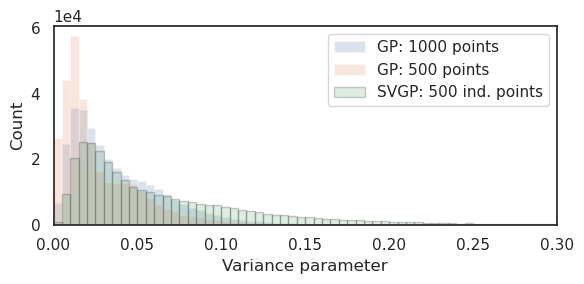

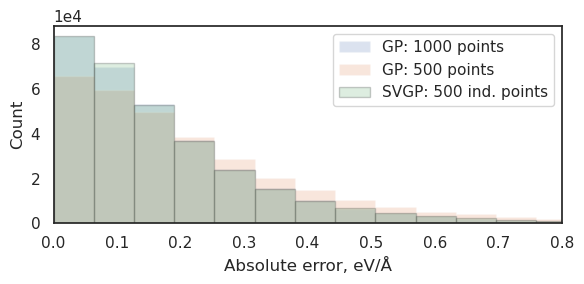

In [38]:
var_exact = forces_predicted_variance_exact[:,:,:]
error_exact = np.abs(forces_predicted_exact[:,:,:] - forces_true[:,:,:])
var_exact_500points = forces_predicted_variance_exact_500points[:,:,:]
error_exact_500points = np.abs(forces_predicted_exact_500points[:,:,:] - forces_true[:,:,:])
var_inducing = forces_predicted_variance_inducing[:,:,:]
error_inducing = np.abs(forces_predicted_inducing[:,:,:] - forces_true[:,:,:])

var_exact = (var_exact - np.min(var_exact)) / (np.max(var_exact) - np.min(var_exact))
var_exact_500points = (var_exact_500points - np.min(var_exact_500points)) / (np.max(var_exact_500points) - np.min(var_exact_500points))
var_inducing = (var_inducing - np.min(var_inducing)) / (np.max(var_inducing) - np.min(var_inducing))

import seaborn as sns
sns.set_theme(style="white")

plt.figure(figsize=(6,3))
plt.hist(var_exact[:,:,:].flatten(), label='GP: 1000 points', alpha=0.2, bins=200)
plt.hist(var_exact_500points[:,:,:].flatten(), label='GP: 500 points', alpha=0.2, bins=200)
plt.hist(var_inducing[:,:,:].flatten(), label='SVGP: 500 ind. points', alpha=0.2, bins=200, edgecolor='black')
plt.xlim(0, 0.3)
plt.legend()
plt.xlabel('Variance parameter')
plt.ylabel('Count')
plt.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
plt.tight_layout()
# plt.savefig('variance.png', dpi=300)
plt.show()


figure = plt.figure(figsize=(6,3))
plt.hist(error_exact[:,:,:].flatten(), label='GP: 1000 points', alpha=0.2, bins=30, range=(0.0, 1.9) )
plt.hist(error_exact_500points[:,:,:].flatten(), label='GP: 500 points', alpha=0.2, bins=30, range=(0.0, 1.9))
plt.hist(error_inducing[:,:,:].flatten(), label='SVGP: 500 ind. points', alpha=0.2, bins=30, range=(0.0, 1.9), edgecolor='black')
plt.xlim(0.0, 0.8)
plt.legend()
plt.xlabel('Absolute error, eV/Å')
plt.ylabel('Count')
plt.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
plt.tight_layout()
# plt.savefig('error.png', dpi=300)
plt.show()


In [39]:
# from ase.visualize import view
# view(test_traj)

<Popen: returncode: None args: ['/home/dlbox2/anaconda3/envs/fande/bin/pytho...>

In [27]:
print( (error_exact_500points[:,:,:].flatten()**2).mean() )
print( (error_inducing[:,:,:].flatten()**2).mean() )
print( (error_exact[:,:,:].flatten()**2).mean() )

0.07821604289422514
0.05008410069654994
0.05044648381005954


In [8]:
epsilon = 0.8

print( (error_exact[:,:,:].flatten()>epsilon).sum()  )

print( (error_exact_500points[:,:,:].flatten()>epsilon).sum() )

print( (error_inducing[:,:,:].flatten()>epsilon).sum() )

1977
4858
1518


In [ ]:
plt.figure(figsize=(6,3))

plt.plot(energy_true - energy_true.min(), label='DFT energy')
plt.plot(energy_predicted_exact - energy_true.min(), label='GP: 1000 points')
# plt.plot(energy_predicted_exact_500points, label='exact_500points')
plt.plot(energy_predicted_inducing - energy_true.min(), label='SVGP: 500 ind. points')
plt.legend()
plt.ylabel('Energy, eV')
plt.xlabel('Step')
plt.tight_layout()
plt.savefig('energy.png', dpi=300)
plt.show()

In [ ]:
snapshot = test_traj[0].copy()

traj_h_dissociation = [snapshot.copy()]

for i in range(110):
        new_snap = snapshot.copy()
        new_snap.positions[388] += i*np.array( (0.02, 0.0, 0.0) )
        traj_h_dissociation.append(new_snap)

view(traj_h_dissociation[0:70])

In [ ]:
%%capture c
var_fly_exact = []
var_fly_exact_500points = []
var_fly_inducing = []

for atoms in tqdm(traj_h_dissociation):
        atoms.calc = fande_calc_exact
        atoms.get_potential_energy()
        var_fly_exact.append(atoms.calc.forces_variance[388])

        atoms.calc = fande_calc_exact_500points
        atoms.get_potential_energy()
        var_fly_exact_500points.append(atoms.calc.forces_variance[388])

        atoms.calc = fande_calc_inducing
        atoms.get_potential_energy()
        var_fly_inducing.append(atoms.calc.forces_variance[388])

In [ ]:
var_fly_exact = np.array(var_fly_exact)
var_fly_exact_500points = np.array(var_fly_exact_500points)
var_fly_inducing = np.array(var_fly_inducing)

plt.figure(figsize=(6,3))
plt.plot(var_fly_exact[:70,:].sum(axis=-1), 'o', label='GP: 1000 points')
plt.plot(var_fly_exact_500points[:70,:].sum(axis=-1), '--', label='GP: 500 points')
plt.plot(var_fly_inducing[:70,:].sum(axis=-1), 'x', label='SVGP: 500 ind. points')
plt.legend()
plt.ylabel('Variance parameter')
plt.xlabel('Step')
plt.tight_layout()
# plt.savefig('variance_fly.png', dpi=300)
plt.show()

In [ ]:
var_fly_exact

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

energy_true = np.array(energy_true)
energy_predicted = np.array(energy_predicted)
energy_errors = energy_predicted - energy_true

forces_true = np.array(forces_true)
forces_predicted = np.array(forces_predicted)
forces_errors = forces_predicted - forces_true

atomic_groups = predictor_loaded.fdm.atomic_groups



for ag in atomic_groups:

    print("Atomic group", ag)
    print("F_x")
    print("MAE", np.mean(np.abs(forces_errors[:, ag, 0].flatten())))
    print("RMSE", np.sqrt(np.mean(forces_errors[:, ag, 0].flatten()**2)))
    print("F_y")
    print("MAE", np.mean(np.abs(forces_errors[:, ag, 1].flatten())))
    print("RMSE", np.sqrt(np.mean(forces_errors[:, ag, 1].flatten()**2)))
    print("F_z")
    print("MAE", np.mean(np.abs(forces_errors[:, ag, 2].flatten())))
    print("RMSE", np.sqrt(np.mean(forces_errors[:, ag, 2].flatten()**2)))
    print("E")
    print("MAE", np.mean(np.abs(energy_errors.flatten())))
    print("RMSE", np.sqrt(np.mean(energy_errors.flatten()**2)))

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
    axs[0].set_title(r"$F_x$")
    axs[0].plot(np.array(forces_true)[:, ag, 0].flatten(), label="true")
    axs[0].plot(np.array(forces_predicted)[:, ag, 0].flatten(), label="predicted")
    axs[0].legend()

    axs[1].set_title(r"$F_y$")
    axs[1].plot(np.array(forces_true)[:, ag, 1].flatten(), label="true")
    axs[1].plot(np.array(forces_predicted)[:, ag, 1].flatten(), label="predicted")
    axs[1].legend()

    axs[2].set_title(r"$F_z$")
    axs[2].plot(np.array(forces_true)[:, ag, 2].flatten(), label="true")
    axs[2].plot(np.array(forces_predicted)[:, ag, 2].flatten(), label="predicted")
    axs[2].legend()

    plt.show()

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))

    axs[0].set_title(r"$F_x$ errors")
    axs[0].hist(forces_errors[:, ag, 0].flatten(), bins=100)

    axs[1].set_title(r"$F_y$ errors")
    axs[1].hist(forces_errors[:, ag, 1].flatten(), bins=100)

    axs[2].set_title(r"$F_z$ errors")
    axs[2].hist(forces_errors[:, ag, 2].flatten(), bins=100)
    plt.show()

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
    axs[0].set_title(r"$E$ errors")
    axs[0].hist(energy_errors.flatten(), bins=100)

    axs[1].set_title(r"$E$")
    axs[1].plot(energy_true, label="true")
    axs[1].plot(energy_predicted, label="predicted")
    axs[1].legend()
    plt.show()
